<a href="https://colab.research.google.com/github/IlyaSilokhin/CartPole-Balancing/blob/main/Cart_Pole_Balancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Initialize the environment

In [ ]:
import numpy as np
import random
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import Model, layers, Input, Sequential
from collections import deque
import os

In [ ]:
env = gym.make('CartPole-v1', render_mode='human')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n

print(f'Number of states: {num_states}')
print(f'Number of actions: {num_actions}')

Number of states: 4
Number of actions: 2


In [ ]:
iters = 10

for i in range(iters):
  obs, info = env.reset()
  done = False
  total_reward = 0

  while not done:
    env.render()
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    done = terminated or truncated

  print(f'Iteration {i}: Total Reward = {total_reward}')
print('Done!')
env.close()

Iteration 0: Total Reward = 17.0
Iteration 1: Total Reward = 24.0
Iteration 2: Total Reward = 25.0
Iteration 3: Total Reward = 11.0
Iteration 4: Total Reward = 13.0
Iteration 5: Total Reward = 31.0
Iteration 6: Total Reward = 9.0
Iteration 7: Total Reward = 11.0
Iteration 8: Total Reward = 27.0
Iteration 9: Total Reward = 27.0
Done!


# 2. Build DQN

In [ ]:
class DQN(Model):
  def __init__(self, state_size, action_size, **kwargs):
    super().__init__(**kwargs)
    self.state_size = state_size
    self.action_size = action_size

    self.net = self.build_model()

  def build_model(self):
    return Sequential([
        Input(shape=(self.state_size,)),
        layers.Dense(units=24, activation='relu', name='layer1'),
        layers.Dense(units=24, activation='relu', name='layer2'),
        layers.Dense(units=self.action_size, activation='linear', name='layer3')
    ])

  def call(self, input):
    return self.net(input)

  def get_config(self):
    config = super().get_config()
    config.update({
        'state_size': self.state_size,
        'action_size': self.action_size
    })
    return config

  @classmethod
  def from_config(cls, config):
    return cls(**config)

# 3. Build Agent

In [ ]:
class Agent:
  def __init__(self, env_name='CartPole-v1', alpha=0.001, gamma=0.99, epsilon_start=1.0, epsilon_decay=0.995, epsilon_end=0):
    self.env = gym.make(env_name)
    self.state_size = self.env.observation_space.shape[0]
    self.action_size = self.env.action_space.n

    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon_start
    self.epsilon_decay = epsilon_decay
    self.epsilon_end = epsilon_end

    self.model = self.build_model()
    self.target_model = self.build_model()
    self.update_target_model()

    self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.alpha)
    self.memory = deque(maxlen = 2000)

  def build_model(self):
    return DQN(self.state_size, self.action_size)

  def update_target_model(self):
    self.target_model.set_weights(self.model.get_weights())

  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))

  def choose_action(self, state):
    if random.uniform(0, 1) < self.epsilon:
      return self.env.action_space.sample()
    else:
      q_values = self.model(np.array([state]))
      return np.argmax(q_values[0].numpy())

  def save_model(self, filepath):
    self.model.save(filepath)

  def load_model(self, filepath):
    self.model = tf.keras.models.load_model(filepath, custom_objects={'DQN': DQN})
    self.target_model = tf.keras.models.load_model(filepath, custom_objects={'DQN': DQN})

  def replay(self, batch_size):
    minibatch = random.sample(self.memory, batch_size)
    for state, action, reward, next_state, done in minibatch:
      with tf.GradientTape() as tape:
        q_values = self.model(np.array([state]), training=True)
        q_value = q_values[0][action]

        if done:
          target = reward
        else:
          next_action = np.argmax(self.model(np.array([state]))[0].numpy())
          t = self.target_model(np.array([next_state]))[0][next_action]
          target = reward + self.gamma * t

        loss = tf.reduce_mean(tf.square(target - q_value))

      grads = tape.gradient(loss, self.model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

  def train(self, filepath, batch_size, episodes_start, episodes_end, update_target_every):
    total_reward_hist = deque(maxlen=episodes_end // 10)
    for e in range(episodes_start, episodes_end):
      state = self.env.reset()[0]
      done = False
      total_reward = 0
      for time_t in range(500):
        action = self.choose_action(state)
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        self.remember(state, action, reward, next_state, done)
        if len(self.memory) >= batch_size:
          self.replay(batch_size)
        state = next_state
        total_reward += reward
        if done:
          print(f'Episode {e}/{episodes_end}, Score: {time_t}, epsilon: {self.epsilon:.2f}')
          break

      if e % update_target_every == 0:
        self.update_target_model()

      self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
      total_reward_hist.append(total_reward)

      """if e % (episodes_end // 50) == 0:
        print(f'Episode {e}: mean total reward = {sum(total_reward_hist) / len(total_reward_hist)}')
        self.save_model(os.path.join(filepath, f'model_{e}.keras'))"""

    self.save_model(os.path.join(filepath, f'model_{episodes_end}.keras'))
    print('Agent has successfully trained!')
    self.env.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filepath = '/content/drive/MyDrive/RL/CartPole/'
batch_size = 32
episodes_end = 500
episodes_start = 0
update_target_every = 5
gamma = 0.95
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995

In [ ]:
training_model_filepath = '/content/drive/MyDrive/RL/CartPole/model_475.keras'

In [ ]:
agent = Agent(gamma=gamma, epsilon_start=epsilon_start, epsilon_decay=epsilon_decay, epsilon_end=epsilon_end)
agent.load_model(training_model_filepath)
agent.train(filepath, batch_size, episodes_start, episodes_end, update_target_every)

# 4. Reload Agent from Memory and Evaluate

In [ ]:
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image

In [ ]:
model_filepath = '/content/drive/MyDrive/RL/CartPole/model_200.keras'
model = Agent(gamma=gamma, epsilon_start=0)
model.load_model(model_filepath)

env = gym.make('CartPole-v1', render_mode='rgb_array')

total_reward_hist = []
for e in range(5):
  frames = []
  state = env.reset()[0]
  done = False
  total_reward = 0
  while not done:
    frame = env.render()
    if frame is not None:
      frames.append(frame)
    action = model.choose_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    state = next_state
    total_reward += reward
    done = terminated or truncated

  imageio.mimsave(f'episodes/episode_{e+1}.gif', frames, duration=0.03)
  total_reward_hist.append(total_reward)
  print(f'Episode {e}: total reward = {total_reward}')

print('Mean total reward:', sum(total_reward_hist) / len(total_reward_hist))
print('\nDone!')
env.close()

Episode 0: total reward = 500.0
Episode 1: total reward = 500.0
Episode 2: total reward = 500.0
Episode 3: total reward = 500.0
Episode 4: total reward = 500.0
Mean total reward: 500.0

Done!


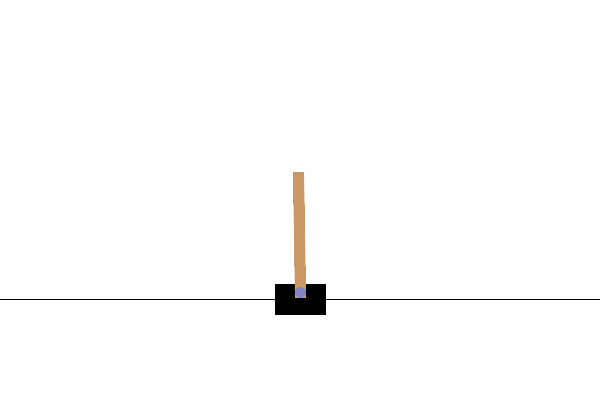

In [ ]:
Image(filename='episodes/episode_3.gif')